<a href="https://colab.research.google.com/github/kazishuvo22/fastMRI-Reconstruction/blob/master/convert_Raw2LowHigh.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import os, glob
import cv2
import numpy as np
import matplotlib.pyplot as plt
import h5py
from tqdm import tqdm
import torch

In [3]:
import transforms as T
import tensorflow as tf
from subsample import RandomMaskFunc

### As there is missing fastmri folder
from fastMRI.data import transforms as T

from fastMRI.common.subsample import MaskFun

In [4]:
# Create a mask function object for undersampling

# randomly sample 4x and 8x accelerations
mask_func = RandomMaskFunc(center_fractions=[0.04, 0.08], accelerations=[8, 4])

# 4x
mask_func_4x = RandomMaskFunc(center_fractions=[0.08], accelerations=[4])

# 8x
mask_func_8x = RandomMaskFunc(center_fractions=[0.04], accelerations=[8])

In [5]:
def sub_sample_kspace(vol, mask_func):
    """
    Transform a kpsace tensor to an undersampled 3D image using mask object 4x or 8x.
    Args:
        vol: kspace tensor
        mask_func: mask function object (4x, 8x)
    Returns:
        sampled_image: output undersampled 3D image volume
    """
    #for low res
    # 1. convert numpy to torch tensor
    kspace2ttensor = T.to_tensor(vol)
    
    # 2. apply mask to kspace
    masked_kspace, mask = T.apply_mask(kspace2ttensor,mask_func)   
    
    # 3. inverse fast fourier transform 2D
    sampled_image = T.ifft2(masked_kspace)
    
    # 4. compute absolute value to get a real image
    sampled_image_abs = T.complex_abs(sampled_image)
    
    # 5. centre crop to 320x320
    cropped_image = T.center_crop(sampled_image_abs, (320, 320))
    
    # 6. Normalize
    #cropped_image_norm, _, _ = normalize_instance(cropped_image, eps=1e-11)

    # 7. convert torch tensor to good old numpy array
    sampled_image = np.abs(cropped_image.numpy())
    
    return sampled_image


def recon_ground_truth(vol):
    '''
    Reconstructs ground truth image from gt tensor of shape (slices, w, h).    
    Args: 
        vol: hdf5 dataset of voulume (slices,w,h) from ESC or RSS
    Returns: 
        recon_img: 3D volume of shape (slice, w, h)
    '''
    
    # Convert to np from hdf5 dataset
    vol_gt = np.array(vol)
    
    ### FOR NORMALIZATION
    
    # Convert to torch tensor
    #gt_tensor = T.to_tensor(vol_gt)
    # Normalize
    #gt_img, _, _ = T.normalize_instance(gt_tensor, eps=1e-11)
    # Convert torch tensor to numpy
    #vol_gt = np.abs(gt_img.numpy())
    
    return vol_gt


def show_slices(data, slice_nums, cmap=None):
    fig = plt.figure(figsize=(16, 16))
    for i, num in enumerate(slice_nums):
        plt.subplot(1, len(slice_nums), i + 1)
        plt.imshow(data[num], cmap=cmap)

In [6]:
def normalize(image):
    flat = image.flatten()
    MIN_BOUND = min(flat)
    MAX_BOUND = max(flat)
    image = (image - MIN_BOUND) / (MAX_BOUND - MIN_BOUND)
    image[image>1] = 1.
    image[image<0] = 0.
    return image

def plot_hist(img):
    img_flat = img.flatten()
    print(min(img_flat), max(img_flat))
    plt.hist(img_flat, bins=20, color='c')
    plt.title("Original input data distribution")
    plt.xlabel("Raw")
    plt.grid(True)
    plt.ylabel("Frequency")
    plt.show()

def show_slices(data, slice_nums, cmap=None):
    fig = plt.figure(figsize=(16, 16))
    for i, num in enumerate(slice_nums):
        plt.subplot(1, len(slice_nums), i + 1)
        plt.imshow(data[num], cmap=cmap)

In [7]:
DIR= "/content/drive/My Drive/CSE499N/Train"
os.listdir(DIR)[:3]

['file1000167.h5', 'file1000317.h5', 'file1000250.h5']

In [8]:
data_files= glob.glob(os.path.join(DIR,'*.h5'))
len(data_files)

101

In [9]:
file = data_files[1]
file

'/content/drive/My Drive/CSE499N/Train/file1000317.h5'

In [10]:
hf = h5py.File(file)
print(type(hf))

<class 'h5py._hl.files.File'>


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: H5pyDeprecationWarning: The default file mode will change to 'r' (read-only) in h5py 3.0. To suppress this warning, pass the mode you need to h5py.File(), or set the global default h5.get_config().default_file_mode, or set the environment variable H5PY_DEFAULT_READONLY=1. Available modes are: 'r', 'r+', 'w', 'w-'/'x', 'a'. See the docs for details.
  """Entry point for launching an IPython kernel.


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: H5pyDeprecationWarning: The default file mode will change to 'r' (read-only) in h5py 3.0. To suppress this warning, pass the mode you need to h5py.File(), or set the global default h5.get_config().default_file_mode, or set the environment variable H5PY_DEFAULT_READONLY=1. Available modes are: 'r', 'r+', 'w', 'w-'/'x', 'a'. See the docs for details.
  """Entry point for launching an IPython kernel.


(32, 640, 372)
(32, 320, 320)


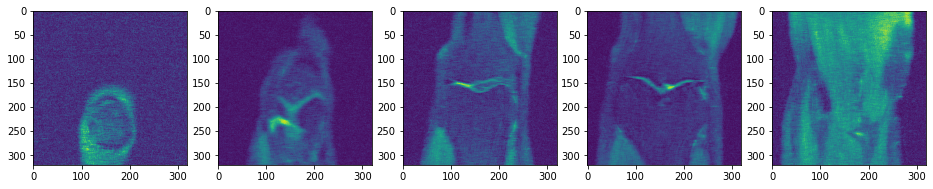

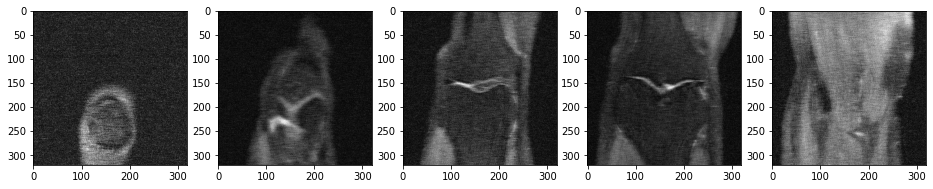

In [11]:
hf = h5py.File(file)
kspace_tensor = hf['kspace'][()]
img_3d = sub_sample_kspace(kspace_tensor, mask_func_4x)
print(kspace_tensor.shape)
print(img_3d.shape)
slice_num = [5,10,15,20,30]
show_slices(img_3d, slice_num)
show_slices(img_3d, slice_num, cmap='gray')

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: H5pyDeprecationWarning: The default file mode will change to 'r' (read-only) in h5py 3.0. To suppress this warning, pass the mode you need to h5py.File(), or set the global default h5.get_config().default_file_mode, or set the environment variable H5PY_DEFAULT_READONLY=1. Available modes are: 'r', 'r+', 'w', 'w-'/'x', 'a'. See the docs for details.
  """Entry point for launching an IPython kernel.


(32, 320, 320)
(32, 320, 320)


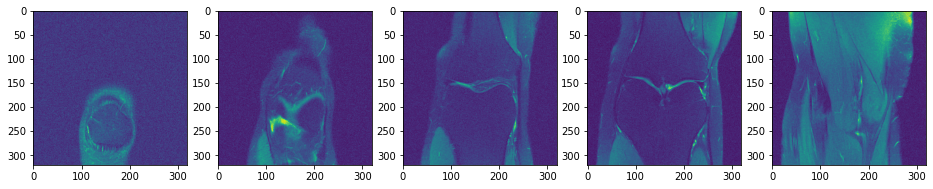

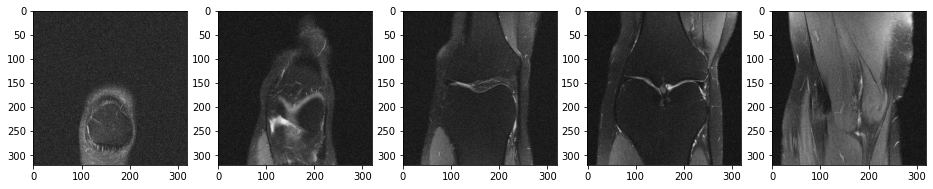

In [14]:
hf = h5py.File(file)
gt_rss = hf['reconstruction_rss']
print(gt_rss.shape)
img_3d_gt = recon_ground_truth(gt_rss)
print(img_3d_gt .shape)

slice_num = [5,10,15,20,30]
show_slices(img_3d_gt, slice_num)
show_slices(img_3d_gt, slice_num, cmap='gray')

In [15]:
high_path = "/content/drive/My Drive/CSE499N/Single Coil 4x/high"
low_path  ="/content/drive/My Drive/CSE499N/Single Coil 4x/low"
high_path,low_path

('/content/drive/My Drive/CSE499N/Single Coil 4x/high',
 '/content/drive/My Drive/CSE499N/Single Coil 4x/low')

### convert low and high resolution image and store in high and low folder

In [16]:
i=0
for file in tqdm(data_files[:]) :
    i+=1
    
    hf = h5py.File(file)
    
    # transform and save low res image
    kspace_tensor = hf['kspace'][()]
    
    img_3d = sub_sample_kspace(kspace_tensor, mask_func_4x)
    
    # Save X 
    np.save("{}/{}.npy".format(low_path, i), img_3d)

    
    # transform and save ground truth(RSS)
    gt_rss = hf['reconstruction_rss'] 
    img_3d_gt = recon_ground_truth(gt_rss)

    #for Y
    img_3d_gt = recon_ground_truth(gt_rss)
    
    
    # Save Y
    np.save("{}/{}.npy".format(high_path, i), img_3d_gt)
print("all file converted kspace to npy")

  0%|          | 0/101 [00:00<?, ?it/s]/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: H5pyDeprecationWarning: The default file mode will change to 'r' (read-only) in h5py 3.0. To suppress this warning, pass the mode you need to h5py.File(), or set the global default h5.get_config().default_file_mode, or set the environment variable H5PY_DEFAULT_READONLY=1. Available modes are: 'r', 'r+', 'w', 'w-'/'x', 'a'. See the docs for details.
  """
100%|██████████| 101/101 [22:03<00:00, 13.10s/it]

all file converted kspace to npy


In [17]:
low_data =glob.glob(os.path.join(low_path,'*.npy'))
high_data= glob.glob(os.path.join(high_path,'*.npy'))
len(low_data), len(high_data)

(101, 101)

In [18]:
low_data[:5]

['/content/drive/My Drive/CSE499N/Single Coil 4x/low/1.npy',
 '/content/drive/My Drive/CSE499N/Single Coil 4x/low/2.npy',
 '/content/drive/My Drive/CSE499N/Single Coil 4x/low/3.npy',
 '/content/drive/My Drive/CSE499N/Single Coil 4x/low/4.npy',
 '/content/drive/My Drive/CSE499N/Single Coil 4x/low/5.npy']

In [19]:
high_data[:5]

['/content/drive/My Drive/CSE499N/Single Coil 4x/high/1.npy',
 '/content/drive/My Drive/CSE499N/Single Coil 4x/high/2.npy',
 '/content/drive/My Drive/CSE499N/Single Coil 4x/high/3.npy',
 '/content/drive/My Drive/CSE499N/Single Coil 4x/high/4.npy',
 '/content/drive/My Drive/CSE499N/Single Coil 4x/high/5.npy']

In [20]:
print("Converted successfully")

Converted successfully
